**Define Models to be used for Synthetic Data Generation - CTGAN and TVAE**

In [5]:
import pandas as pd
import numpy as np
import time

from sdv.tabular import TVAE
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate

import warnings
warnings.filterwarnings('ignore')

c:\Users\user\anaconda3\envs\saq\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:


models_tvae = []
models_ctgan = []

for i in range(6):
    models_ctgan.append(CTGAN(batch_size=300, verbose=True, epochs=80))
    models_tvae.append(TVAE(batch_size=300, epochs=80))

In [6]:
df1 = pd.read_csv("dataset/adult.csv")
df1.name = "adult"

df2 = pd.read_csv("dataset/breast_cancer.csv")
df2.name = "breast_cancer"

df3 = pd.read_csv("dataset/heart_cleveland_upload.csv")
df3.name = "heart"

df4 = pd.read_csv("dataset/Iris.csv")
df4.name = "iris"

df5 = pd.read_csv("dataset/creditcard.csv")
df5.name = "credit"


In [7]:
dfs = [df1, df2, df3, df4, df5]

# To store generated synthetic data
synthetic_data_mapping = {}

metrics=['CSTest', 'KSTest', 'ContinuousKLDivergence', 'DiscreteKLDivergence']
saved_models = {}

In [8]:
for df in dfs:
    print('\n' + '%'*40)
    print('\033[1m' + df.name + '\033[0m')
    print('%'*40 + '\n')
    df.info()
    display(df.head())
    synthetic_data_mapping['syn_' + df.name] = []


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
adult
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
breast_cancer
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-nul

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
heart
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
iris
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
credit
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
dfs=[df1, df2, df3, df4, df5]

In [13]:

def evaluate_model(model, df):
    
    print('Training in Progress - ' + model.__class__.__name__ + '_' + df.name + '\n')
    
    # Record training time
    start = time.time()
    model.fit(df)
    end = time.time()
    
    print( '\n' + model.__class__.__name__ + ' trained. \nTraining time: ' + str(end-start) + ' seconds \n')
    syn_data = model.sample(len(df))
    syn_data.name = df.name + '-' + model.__class__.__name__

    # Save Generated Synthetic Data for each model in a dictionary 
    synthetic_data_mapping['syn_' + df.name].append(syn_data)    
    
    # Record evaluation time
    start = time.time()
    ee = evaluate(syn_data, df, metrics=metrics , aggregate=False)
    end = time.time()
    print("Synthetic Data Evaluation - " +  model.__class__.__name__ + '_' + df.name + '\n')
    display(ee)
    print('\nEvaluation time: ' + str(end-start) + ' seconds \n')
    
    
    # Save the model
    saved_model_name = model.__class__.__name__ + '_' + df.name + '.pkl'
    model.save(saved_model_name)
    saved_models[saved_model_name] = model

In [14]:

k = 0;
for df in dfs:
    evaluate_model(models_ctgan[k], df)
    evaluate_model(models_tvae[k], df)
    k += 1

Training in Progress - CTGAN_adult

Epoch 1, Loss G:  1.8685,Loss D:  0.0563
Epoch 2, Loss G:  1.6792,Loss D: -0.2535
Epoch 3, Loss G:  0.9279,Loss D:  0.0400
Epoch 4, Loss G:  0.7681,Loss D:  0.1241
Epoch 5, Loss G:  0.4424,Loss D:  0.1682
Epoch 6, Loss G: -0.0655,Loss D:  0.0633
Epoch 7, Loss G: -0.4143,Loss D: -0.1362
Epoch 8, Loss G: -0.5869,Loss D: -0.1208
Epoch 9, Loss G: -0.7749,Loss D:  0.0743
Epoch 10, Loss G: -0.6527,Loss D: -0.2738
Epoch 11, Loss G: -0.8440,Loss D: -0.0667
Epoch 12, Loss G: -0.7871,Loss D:  0.0467
Epoch 13, Loss G: -0.7728,Loss D:  0.0755
Epoch 14, Loss G: -0.7612,Loss D: -0.3725
Epoch 15, Loss G: -0.6611,Loss D: -0.0956
Epoch 16, Loss G: -0.3788,Loss D: -0.1701
Epoch 17, Loss G: -0.4856,Loss D:  0.0519
Epoch 18, Loss G: -0.6974,Loss D: -0.0893
Epoch 19, Loss G: -0.3855,Loss D: -0.1969
Epoch 20, Loss G: -0.1117,Loss D: -0.1202
Epoch 21, Loss G: -0.2463,Loss D: -0.3222
Epoch 22, Loss G:  0.2255,Loss D:  0.1408
Epoch 23, Loss G: -0.5028,Loss D: -0.3305
Epoch 2

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.965614,0.965614,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.809368,0.809368,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.932605,0.932605,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.862528,0.862528,0.0,1.0,MAXIMIZE,None



Evaluation time: 1.269083023071289 seconds 

Training in Progress - TVAE_adult


TVAE trained. 
Training time: 133.27374362945557 seconds 

Synthetic Data Evaluation - TVAE_adult



,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.997360,0.997360,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.815029,0.815029,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.856174,0.856174,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.895526,0.895526,0.0,1.0,MAXIMIZE,None



Evaluation time: 1.1685633659362793 seconds 

Training in Progress - CTGAN_breast_cancer

Epoch 1, Loss G:  0.8564,Loss D:  0.0262
Epoch 2, Loss G:  0.7992,Loss D:  0.0021
Epoch 3, Loss G:  0.8013,Loss D: -0.0627
Epoch 4, Loss G:  0.8105,Loss D: -0.0505
Epoch 5, Loss G:  0.8078,Loss D: -0.1251
Epoch 6, Loss G:  0.8331,Loss D: -0.1699
Epoch 7, Loss G:  0.7357,Loss D: -0.1464
Epoch 8, Loss G:  0.7601,Loss D: -0.2685
Epoch 9, Loss G:  0.8159,Loss D: -0.3485
Epoch 10, Loss G:  0.7725,Loss D: -0.3719
Epoch 11, Loss G:  0.7097,Loss D: -0.4435
Epoch 12, Loss G:  0.5989,Loss D: -0.4932
Epoch 13, Loss G:  0.5313,Loss D: -0.4799
Epoch 14, Loss G:  0.3922,Loss D: -0.5571
Epoch 15, Loss G:  0.4123,Loss D: -0.5464
Epoch 16, Loss G:  0.1231,Loss D: -0.5632
Epoch 17, Loss G:  0.1801,Loss D: -0.4814
Epoch 18, Loss G: -0.0335,Loss D: -0.6273
Epoch 19, Loss G: -0.1423,Loss D: -0.4188
Epoch 20, Loss G: -0.2769,Loss D: -0.3428
Epoch 21, Loss G: -0.3604,Loss D: -0.4324
Epoch 22, Loss G: -0.3999,Loss D: -0

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.827354,0.827354,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.636039,0.636039,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.348180,0.348180,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,None



Evaluation time: 1.076092004776001 seconds 

Training in Progress - TVAE_breast_cancer


TVAE trained. 
Training time: 12.544710159301758 seconds 

Synthetic Data Evaluation - TVAE_breast_cancer



,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.749063,0.749063,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.771199,0.771199,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.710157,0.710157,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,None



Evaluation time: 1.0734448432922363 seconds 

Training in Progress - CTGAN_heart

Epoch 1, Loss G:  0.7805,Loss D:  0.0101
Epoch 2, Loss G:  0.7414,Loss D:  0.0381
Epoch 3, Loss G:  0.7406,Loss D: -0.0322
Epoch 4, Loss G:  0.7686,Loss D: -0.0324
Epoch 5, Loss G:  0.7308,Loss D:  0.0208
Epoch 6, Loss G:  0.7211,Loss D: -0.0428
Epoch 7, Loss G:  0.6826,Loss D: -0.0493
Epoch 8, Loss G:  0.7179,Loss D: -0.0422
Epoch 9, Loss G:  0.7093,Loss D: -0.0585
Epoch 10, Loss G:  0.6482,Loss D: -0.0959
Epoch 11, Loss G:  0.6590,Loss D: -0.0209
Epoch 12, Loss G:  0.6883,Loss D: -0.0361
Epoch 13, Loss G:  0.6601,Loss D: -0.0762
Epoch 14, Loss G:  0.6555,Loss D: -0.1094
Epoch 15, Loss G:  0.5763,Loss D: -0.0616
Epoch 16, Loss G:  0.5348,Loss D: -0.1417
Epoch 17, Loss G:  0.5267,Loss D: -0.0978
Epoch 18, Loss G:  0.4455,Loss D: -0.1405
Epoch 19, Loss G:  0.4329,Loss D: -0.1903
Epoch 20, Loss G:  0.3281,Loss D: -0.0298
Epoch 21, Loss G:  0.3698,Loss D:  0.0035
Epoch 22, Loss G:  0.3675,Loss D: -0.0191
Ep

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.812891,0.812891,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.645637,0.645637,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."



Evaluation time: 0.21770787239074707 seconds 

Training in Progress - TVAE_heart


TVAE trained. 
Training time: 2.828680992126465 seconds 

Synthetic Data Evaluation - TVAE_heart



,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.678932,0.678932,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.592085,0.592085,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."



Evaluation time: 0.2162940502166748 seconds 

Training in Progress - CTGAN_iris

Epoch 1, Loss G:  1.1485,Loss D: -0.0368
Epoch 2, Loss G:  1.1816,Loss D: -0.0435
Epoch 3, Loss G:  1.1747,Loss D: -0.0191
Epoch 4, Loss G:  1.1046,Loss D: -0.0458
Epoch 5, Loss G:  1.1241,Loss D: -0.0791
Epoch 6, Loss G:  1.1221,Loss D: -0.0547
Epoch 7, Loss G:  1.1161,Loss D: -0.0357
Epoch 8, Loss G:  1.0896,Loss D: -0.0821
Epoch 9, Loss G:  1.0386,Loss D: -0.0884
Epoch 10, Loss G:  1.0701,Loss D: -0.0717
Epoch 11, Loss G:  1.0171,Loss D: -0.1206
Epoch 12, Loss G:  1.0403,Loss D: -0.0702
Epoch 13, Loss G:  1.0479,Loss D: -0.0624
Epoch 14, Loss G:  1.0526,Loss D: -0.0567
Epoch 15, Loss G:  1.0333,Loss D: -0.0247
Epoch 16, Loss G:  0.9338,Loss D: -0.0457
Epoch 17, Loss G:  0.9886,Loss D: -0.0850
Epoch 18, Loss G:  0.9292,Loss D: -0.0274
Epoch 19, Loss G:  0.9550,Loss D:  0.0028
Epoch 20, Loss G:  0.9155,Loss D: -0.0457
Epoch 21, Loss G:  0.9281,Loss D: -0.1476
Epoch 22, Loss G:  0.9050,Loss D: -0.0812
Epo

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.999600,0.999600,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.530667,0.530667,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.114321,0.114321,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,None



Evaluation time: 0.03178548812866211 seconds 

Training in Progress - TVAE_iris


TVAE trained. 
Training time: 1.6024680137634277 seconds 

Synthetic Data Evaluation - TVAE_iris



,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.999867,0.999867,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.746667,0.746667,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.219804,0.219804,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,None



Evaluation time: 0.032778024673461914 seconds 

Training in Progress - CTGAN_credit

Epoch 1, Loss G: -2.7659,Loss D:  0.2384
Epoch 2, Loss G: -4.1002,Loss D:  0.2293
Epoch 3, Loss G: -4.0083,Loss D:  0.1530
Epoch 4, Loss G: -3.8763,Loss D: -0.4940
Epoch 5, Loss G: -4.0641,Loss D: -0.0662
Epoch 6, Loss G: -4.1364,Loss D: -0.0784
Epoch 7, Loss G: -4.1208,Loss D: -0.1869
Epoch 8, Loss G: -3.3686,Loss D:  0.0560
Epoch 9, Loss G: -3.3435,Loss D:  0.0349
Epoch 10, Loss G: -3.0418,Loss D: -0.1783
Epoch 11, Loss G: -3.0586,Loss D: -0.1566
Epoch 12, Loss G: -2.6408,Loss D:  0.0556
Epoch 13, Loss G: -2.5214,Loss D: -0.1170
Epoch 14, Loss G: -2.6091,Loss D: -0.2129
Epoch 15, Loss G: -2.2597,Loss D: -0.0207
Epoch 16, Loss G: -2.3262,Loss D: -0.0476
Epoch 17, Loss G: -1.7925,Loss D: -0.0567
Epoch 18, Loss G: -1.8195,Loss D:  0.1520
Epoch 19, Loss G: -2.0096,Loss D:  0.4334
Epoch 20, Loss G: -1.4826,Loss D:  0.1129
Epoch 21, Loss G: -1.4132,Loss D:  0.4122
Epoch 22, Loss G: -0.5292,Loss D:  0.0361

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.818255,0.818255,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.728005,0.728005,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."



Evaluation time: 18.377869606018066 seconds 

Training in Progress - TVAE_credit


TVAE trained. 
Training time: 3825.797990322113 seconds 

Synthetic Data Evaluation - TVAE_credit



,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.930434,0.930434,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.969049,0.969049,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."



Evaluation time: 51.81213188171387 seconds 



In [15]:
saved_models

{'CTGAN_adult.pkl': <sdv.tabular.ctgan.CTGAN at 0x1b6777961f0>,
 'TVAE_adult.pkl': <sdv.tabular.ctgan.TVAE at 0x1b607482bb0>,
 'CTGAN_breast_cancer.pkl': <sdv.tabular.ctgan.CTGAN at 0x1b677681b50>,
 'TVAE_breast_cancer.pkl': <sdv.tabular.ctgan.TVAE at 0x1b675086c40>,
 'CTGAN_heart.pkl': <sdv.tabular.ctgan.CTGAN at 0x1b67751c3d0>,
 'TVAE_heart.pkl': <sdv.tabular.ctgan.TVAE at 0x1b67751c460>,
 'CTGAN_iris.pkl': <sdv.tabular.ctgan.CTGAN at 0x1b60749e190>,
 'TVAE_iris.pkl': <sdv.tabular.ctgan.TVAE at 0x1b60749e1c0>,
 'CTGAN_credit.pkl': <sdv.tabular.ctgan.CTGAN at 0x1b60749e370>,
 'TVAE_credit.pkl': <sdv.tabular.ctgan.TVAE at 0x1b60749e3a0>}

In [25]:
%store synthetic_data_mapping

Stored 'synthetic_data_mapping' (dict)


In [26]:
%store df1
%store df2
%store df3
%store df4
%store df5

Stored 'df1' (DataFrame)
Stored 'df2' (DataFrame)
Stored 'df3' (DataFrame)
Stored 'df4' (DataFrame)
Stored 'df5' (DataFrame)


In [29]:
%store df1.name
%store df2.name
%store df3.name
%store df4.name
%store df5.name

UsageError: Unknown variable 'df1.name'


In [17]:
synthetic_data_mapping['syn_' + df1.name][0].head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,35,Private,170472,10th,13,Divorced,Exec-managerial,Not-in-family,White,Female,0,1,32,United-States,<=50K
1,63,?,111842,HS-grad,9,Widowed,?,Unmarried,White,Female,4,0,12,United-States,<=50K
2,17,?,86605,10th,8,Never-married,?,Own-child,White,Female,21,1,10,United-States,<=50K
3,33,Private,130340,Some-college,10,Married-civ-spouse,Farming-fishing,Own-child,White,Male,13,1,30,United-States,<=50K
4,52,Private,165133,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Other-relative,White,Female,0,0,40,Philippines,<=50K


In [18]:
synthetic_data_mapping['syn_' + df1.name][1].name

'adult-TVAE'

**Visualisation**

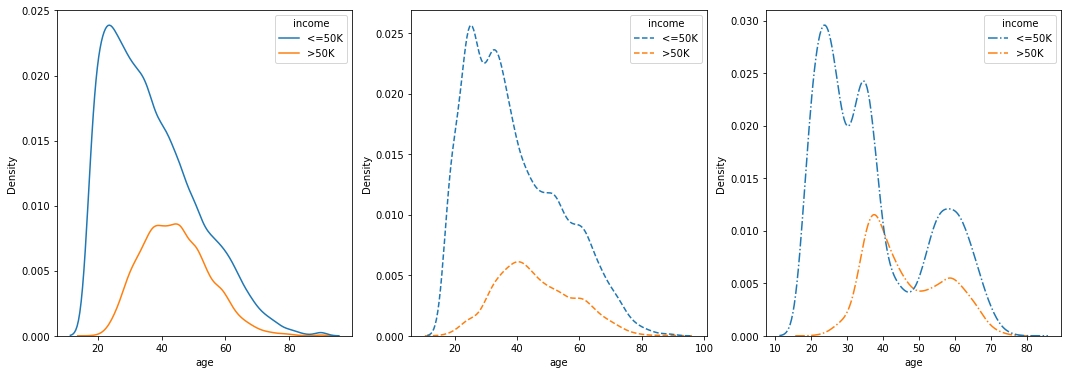

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
sns.kdeplot(data=df1,ax=ax0, x='age', hue='income')
sns.kdeplot(data=synthetic_data_mapping['syn_' + df1.name][0],ax=ax1, x='age', hue='income', label='ctgan', ls='--')
sns.kdeplot(data=synthetic_data_mapping['syn_' + df1.name][1],ax=ax2, x='age', hue='income', label='tvae', ls='-.')
plt.show()

In [23]:
obj_data = df1.select_dtypes(include=['object']).copy()
obj_data.head()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,?,HS-grad,Widowed,?,Not-in-family,White,Female,United-States,<=50K
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K
2,?,Some-college,Widowed,?,Unmarried,Black,Female,United-States,<=50K
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K


In [ ]:
synthetic_data_mapping[df1.name][1].groupby(['income']).size()

income
<=50K    24998
>50K      7563
dtype: int64

In [ ]:
synthetic_data_mapping[df1.name][0].groupby(['income']).size()

income
<=50K    26731
>50K      5830
dtype: int64

In [ ]:
df1.groupby('income').size()

income
<=50K    24720
>50K      7841
dtype: int64

In [24]:
# VBGMM
from sklearn.mixture import GaussianMixture

vbgmm = GaussianMixture(n_components=3, random_state=42)
col = df1['education.num'].values.reshape(-1,1)
vbg = vbgmm.fit(col)
vbg.means_.shape
vbg.means_

array([[ 9.45084037],
       [13.16587431],
       [ 5.65350733]])

**VAE for Adult Census Data**

In [ ]:

"""import statsmodels.api as sm

m = sm.OLS.from_formula("income_code~ age + fnlwgt+ education_num + capital_gain + capital_loss + hours_per_week", merged_df)"""

'import statsmodels.api as sm\n\nm = sm.OLS.from_formula("income_code~ age + fnlwgt+ education_num + capital_gain + capital_loss + hours_per_week", merged_df)'